In [9]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [10]:
import csv
import os

In [11]:
# Determine important landmarks for plank
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX",
]

# Generate all columns of the data frame

HEADERS = ["label"] # Label column

for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [12]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    

def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Ignore if file is already exist
    if os.path.exists(dataset_path):
        return

    # Write all the columns to a empaty file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(HEADERS)


def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def remove_duplicate_rows(dataset_path: str):
    '''
    Remove duplicated data from the dataset then save it to another files
    '''
    
    df = pd.read_csv(dataset_path)
    df.drop_duplicates(keep="first", inplace=True)
    df.to_csv(f"cleaned_train.csv", sep=',', encoding='utf-8', index=False)
    

def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)

In [6]:
FOLDER_PATH = "C:/Users/Alrowad/Exercise-correction/plank_model/dataset/train"
picture_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH) if os.path.isfile(os.path.join(FOLDER_PATH, f))]
print(f"Total pictures: {len(picture_files)}")

DATASET_PATH = "./CSV_dataset/train.csv"
saved_counts = 0

init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:
    index = 0
    
    while True:
        if index == len(picture_files):
            break
        
        file_path = picture_files[index]

        image = cv2.imread(file_path)

        # Flip image horizontally for more data
        image = cv2.flip(image, 1)

        # Reduce size of a frame
        if image.shape[1] > 500:
            image = cv2.resize(image, (500, int(image.shape[0] * 500 / image.shape[1])))

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {saved_counts}", (20, 20), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
        
        cv2.imshow("CV2", image)

        k = cv2.waitKey(1) & 0xFF

        if k == ord('d'): 
            index += 1
        # Press C to save as correct form
        elif k == ord('c'): 
            export_landmark_to_csv(DATASET_PATH, results, "C")
            saved_counts += 1
        # Press L to save as low back
        elif k == ord("l"):
            export_landmark_to_csv(DATASET_PATH, results, "L")
            saved_counts += 1
        # Press L to save as high back
        elif k == ord("h"):
            export_landmark_to_csv(DATASET_PATH, results, "H")
            saved_counts += 1
        elif k == ord("f"):
            index += 1
            os.remove(file_path)
        elif k == ord("q"):
            break
        else:
            continue

        # # Press Q to close cv2 window
        # if cv2.waitKey(1) & 0xFF == ord('d'):
        #     index += 1

        # # Press Q to close cv2 window
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Close cv2 window
    cv2.destroyAllWindows()

Total pictures: 2418


In [7]:
df = describe_dataset(DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

<AxesSubplot:xlabel='label', ylabel='count'>

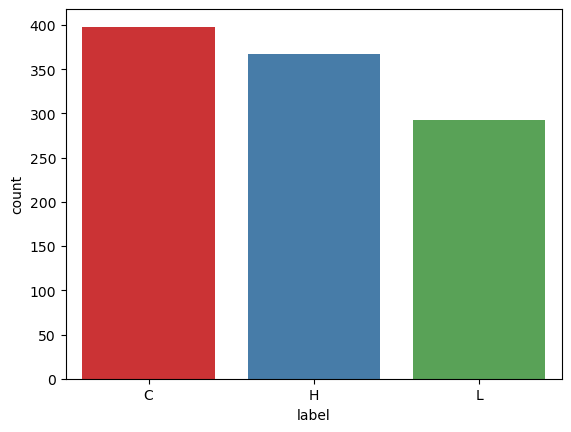

In [8]:
sns.countplot(x='label', data=df, palette="Set1") 

In [13]:
FOLDER_PATH = "C:/Users/Alrowad/Exercise-correction/plank_model/dataset/test"
picture_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH) if os.path.isfile(os.path.join(FOLDER_PATH, f))]
print(f"Total pictures: {len(picture_files)}")

DATASET_PATH = "./CSV_dataset/test.csv"
saved_counts = 0

init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:
    index = 0
    
    while True:
        if index == len(picture_files):
            break
        
        file_path = picture_files[index]

        image = cv2.imread(file_path)

        # Flip image horizontally for more data
        image = cv2.flip(image, 1)

        # Reduce size of a frame
        if image.shape[1] > 500:
            image = cv2.resize(image, (500, int(image.shape[0] * 500 / image.shape[1])))

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {saved_counts}", (20, 20), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
        
        cv2.imshow("CV2", image)

        k = cv2.waitKey(1) & 0xFF

        if k == ord('d'): 
            index += 1
        # Press C to save as correct form
        elif k == ord('c'): 
            export_landmark_to_csv(DATASET_PATH, results, "C")
            saved_counts += 1
        # Press L to save as low back
        elif k == ord("l"):
            export_landmark_to_csv(DATASET_PATH, results, "L")
            saved_counts += 1
        # Press L to save as high back
        elif k == ord("h"):
            export_landmark_to_csv(DATASET_PATH, results, "H")
            saved_counts += 1
        elif k == ord("f"):
            index += 1
            os.remove(file_path)
        elif k == ord("q"):
            break
        else:
            continue

        # # Press Q to close cv2 window
        # if cv2.waitKey(1) & 0xFF == ord('d'):
        #     index += 1

        # # Press Q to close cv2 window
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Close cv2 window
    cv2.destroyAllWindows()

Total pictures: 526


In [14]:
test_df = describe_dataset(DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

<AxesSubplot:xlabel='count', ylabel='label'>

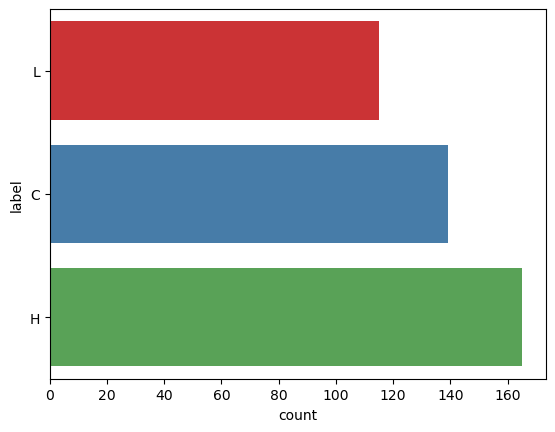

In [15]:
sns.countplot(y='label', data=test_df, palette="Set1") 